# Introduction

This notebook is a cute example of how a well-known, deep learning architecture can be modified and then used to solve a problem it is not usually associated with.

The problem in question is predicting the sales of tickets for live events ("shows"), and comes from a real world example.  We had access to a detailed quantity of metadata for about 200 shows (with each show having several performances, so around 1500 performances in total).  We also had the final 20 weeks of ticket sales (during which the vast majority of sales occured).  The challenge was to forecast future sales - up to the point of the performance - using the first few weeks of sales.

When building ML models, our goal is to develop the _simplest_ model which achieves the best (and most robust) fits to data.  During my exploration of different models I experimented with a number of linear, non-linear, state-space and smoothing-based approaches.  All were unable to produce robust predictions.

The deep learning approach I settled upon took advantage of the fact that the sales periods were a fixed 20 weeks.  I started with a seq2seq architecture and added a few bells and whistles.  Even with single-layer LSTMs and no attention mechanism the results were a dramatic improvement on everything I had tried previously, and a substantial improvement on the "human judgement" forecasts produced prior to this.

In [1]:
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import optim
from torch.utils.data import DataLoader
import random
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
RANDOM_SEED = 42

sns.set(rc={'figure.figsize':(20,10)})

# 1. Load the data

The data here have been obfuscated and heavily preprocessed (since preprocessing is not the point of this notebook). What is loaded in is ready to work with.  The source data is not being committed to this repo because I do not own it.

In [3]:
static_data = torch.from_numpy(np.load('static_data_preprocessed.npy'))
static_data.size()

torch.Size([1533, 54])

The `static_data` tensor contains a mix of categorical, ordinal and numeric data that relate both to a show and to a specific performance.  The categorical data have been one-hot encoded.  The ordinal have been encoded as integers.  The numerics have been left untouched.

Some examples of the kinds of data that have been included:
- Information about the star power of the cast, whether there is local competition, whether there has been a marketing drive.
- Season, day and time of the performance.
- Capacity of the theatre and length of the "early bird" sales period.

An example row from this tensor is shown below:

In [4]:
static_data[0]

tensor([  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   3.,   1.,   2.,   1.,   1.,   3.,   4.,
          4.,   4.,   3.,   0., 471.,  45.], dtype=torch.float64)

In [5]:
dynamic_data = torch.from_numpy(np.load('dynamic_data_preprocessed.npy'))
dynamic_data.size()

torch.Size([1533, 20, 3])

For each performance, we have weekly sales data for the final 20 weeks.  We have two variables: the ticket price (which has been standardised to aid obfusacation) and the cumulative percentage of venue capacity that has been sold to date.  We add another variable to these two: the fraction of weeks (using a denominator of 20) until the performance.  This was found to help the model adjust it's predictions as the sale period closed out.

In [6]:
# Adding the number of weeks until the performance to the dynamic data.
n_weeks = dynamic_data.size(1)
n_examples = dynamic_data.size(0)
weeks_tensor = torch.tensor(1./np.arange(1, n_weeks+1)).view(1, -1, 1)
weeks_tensor = weeks_tensor.repeat(n_examples, 1, 1)
dynamic_data = torch.concat([weeks_tensor, dynamic_data], dim=2)
dynamic_data[0]

tensor([[ 1.0000,  1.0000, 33.6000,  0.3000],
        [ 0.5000,  0.5000, 33.6000,  0.3046],
        [ 0.3333,  0.3333, 33.6000,  0.3113],
        [ 0.2500,  0.2500, 33.6000,  0.3251],
        [ 0.2000,  0.2000, 35.0000,  0.3333],
        [ 0.1667,  0.1667, 35.0000,  0.3441],
        [ 0.1429,  0.1429, 35.0000,  0.3549],
        [ 0.1250,  0.1250, 35.0000,  0.3659],
        [ 0.1111,  0.1111, 35.0000,  0.3683],
        [ 0.1000,  0.1000, 35.0000,  0.3741],
        [ 0.0909,  0.0909, 35.0000,  0.4204],
        [ 0.0833,  0.0833, 35.0000,  0.4308],
        [ 0.0769,  0.0769, 35.0000,  0.4350],
        [ 0.0714,  0.0714, 35.7429,  0.4745],
        [ 0.0667,  0.0667, 36.3000,  0.4961],
        [ 0.0625,  0.0625, 36.3000,  0.5520],
        [ 0.0588,  0.0588, 36.3000,  0.5710],
        [ 0.0556,  0.0556, 36.5143,  0.5830],
        [ 0.0526,  0.0526, 36.8000,  0.5876],
        [ 0.0500,  0.0500, 36.8000,  0.6365]], dtype=torch.float64)

Each show has between 1 and 10 performances in this dataset.  We expect some similarity in the patterns of sales to occur between different performances of the same show.  (Indeed, a more sophisticated model than this one would probably take advantage of this!)

To ensure that no information travels between the training and validation datasets, we split our data using the `show_id`, not the `performance_id`.  The following map helps us to do this.

In [7]:
show_map_df = pd.read_csv('show_map_preprocessed.csv')
show_map_df.head(3)

,show_id,performance_id
0,0,0
1,0,1
2,1,2


# 2. Split the data into training and validation sets

As discussed above, we split the shows into training and validation sets, locate all performances for shows in each and build the required tensors.

We load the tensors onto the GPU, if available.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device type: {device.type}")

Using device type: cuda


In [8]:
train_shows, test_shows = train_test_split(
    show_map_df.show_id.unique(), 
    train_size=0.8, 
    shuffle=True, 
    random_state=RANDOM_SEED
)

In [10]:
# Find the indexes of the performances belonging to each show.
train_indexes = torch.tensor(np.where(show_map_df.show_id.isin(train_shows))[0])
test_indexes = torch.tensor(np.where(show_map_df.show_id.isin(test_shows))[0])

# Arrays of performance_ids
train_keys = show_map_df[show_map_df.show_id.isin(train_shows)].performance_id.values
test_keys = show_map_df[show_map_df.show_id.isin(test_shows)].performance_id.values

# Show & performance metadata
static_train = torch.index_select(static_data, 0, train_indexes).to(device).float()
static_test = torch.index_select(static_data, 0, test_indexes).to(device).float()

# Weekly sales and pricing data
dynamic_train = torch.index_select(dynamic_data, 0, train_indexes).to(device).float()
dynamic_test = torch.index_select(dynamic_data, 0, test_indexes).to(device).float()

# 3. Some simple visualisations

<AxesSubplot:xlabel='week', ylabel='pct.capacity'>

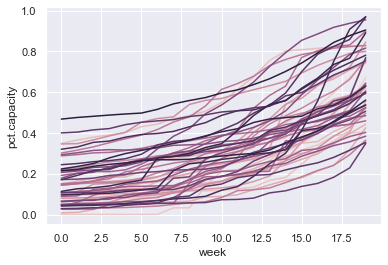

In [11]:
def sample_performance(i):
    idx = np.random.choice(dynamic_train.shape[0])
    data = dynamic_train[idx, :, -1]
    return pd.DataFrame([
        {'performance_id': i, 'week': w, 'pct.capacity': t.item()}
        for w, t in enumerate(data)
    ])

data = pd.concat([sample_performance(i) for i in range(50)], ignore_index=True)

sns.lineplot(x='week', y='pct.capacity', hue='performance_id', data=data, legend=None)

This sample of sales curves shows a great deal of variety.  We have examples of linear, sub-linear and super-linear growth in sold capacity, as well as some more complex saturating-sigmoid type curves.  A handful of the sales curves show sudden jumps in sold capacity.  Apparently this is due to third party agents reporting large blocks of sales all in one go.  Clearly, artefacts like this make predictions difficult - unless we are somehow able to collect additional data that might suggest that these blocks of sales are expected.

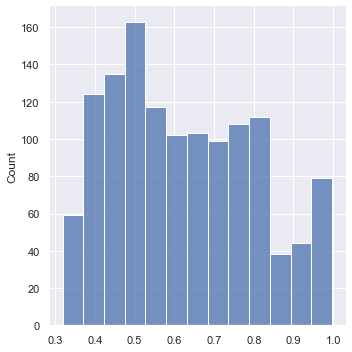

In [12]:
sns.displot(
    data = dynamic_train[:, -1, -1].to('cpu')
)

The plot above shows the distibution of final % capacities sold across each of the performances.  Again, significant variation and no clear, unimodal distribution.

# 4. Datasets and Dataloaders

With 20 weeks of sales data, we will use the first 10 weeks to predict the final 10 weeks.  We call the first 10 weeks the `lookback` timeframe and the final 10 weeks the `lookahead` timeframe.

In [13]:
lookback = 10
lookahead = dynamic_data.size(1) - lookback
print(f"lookahead is {lookahead}")

lookahead is 10


The following code implements a custom dataset.  Yielding a value via `__getitem__()` results in the following:

1. A scalar `performance_id`, so that we can reference the performance if we want to.
2. A size (54) tensor called `static_data` which contains the show and performance metadata.
3. A size (`lookback`, 3) tensor called `past_tensor` which contains pricing, sales and week encoding.
4. A size (`lookahead`, 3) tensor called `future_tensor` which contains pricing, sales and week encoding.  Importantly, the sold capacity data is offset by 1 week, meaning that the decoder model is fed with the _previous_ week's sold capacity and the _current_ week's week encoding and pricing data.
5. A size (`lookahead`) tensor called `target_tensor` which contains future sold capacity values.  This is used to compare the model's prediction of the next week's sales with the actual sales seen.

An additional method, `get_by_key()`, allows us to return the tensors for a specific `performance_id`.  This is helpful for debugging, and for illustrating particular fits later on.

In [14]:
from torch.utils.data import Dataset

class TensorSizeMismatch(Exception):
    """Raised when the static and dynamic tensors have a different size along the 0th axis."""
    pass

class InvalidWeekSplit(Exception):
    """Raised when the split between training and test weeks is not valid."""
    pass

class InvalidKey(Exception):
    """Raised when an invalid performance_id is requested."""
    pass

class ShowDataset(torch.utils.data.Dataset):
    
    def __init__(self, keys, static_data, dynamic_data, lookback=10):
        
        if static_data.size(0) != dynamic_data.size(0):
            raise TensorSizeMismatch()

        self.static_data_ = static_data
        self.dynamic_data_ = dynamic_data
        self.keys_ = np.array(keys)
        
        self.n_weeks_  = dynamic_data.size(1)
        self.lookback_ = lookback
        
        if self.n_weeks_ <= self.lookback_:
            raise(InvalidWeekSplit)
        else:
            self.lookahead_ = self.n_weeks_ - self.lookback_
                
    def __len__(self):
        return self.dynamic_data_.size(0)

    def __getitem__(self, idx):
        return (
            self.keys_[idx],
            # Static Tensor
            self.static_data_[idx], 
            # Past Tensor
            self.dynamic_data_[idx, 0:self.lookback_], 
            # Future Tensor
            torch.concat([
                self.dynamic_data_[idx, self.lookback_:self.lookback_+self.lookahead_, :-1],
                self.dynamic_data_[idx, self.lookback_-1:self.lookback_+self.lookahead_-1, -1].unsqueeze(1)
            ], dim=1),
            # Target Tensor
            self.dynamic_data_[idx, self.lookback_:self.lookback_+self.lookahead_, -1]
        )
    
    def get_by_key(self, key):
        try:
            idx = np.where(self.keys_ == key)[0][0]
            return self.__getitem__(idx)
        except IndexError:
            raise InvalidKey()

In [15]:
train_dataset = ShowDataset(train_keys, static_train, dynamic_train, lookback=lookback)
test_dataset = ShowDataset(test_keys, static_test, dynamic_test, lookback=lookback)

We wrap the training and test datasets up into dataloaders that will serve batches of examples.  Small batches were found to work better than large batches for this dataset.

In [16]:
batch_size = 16

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 5. Model Definition

The model is a variant of a simple seq2seq architecture, with no attention mechanism.  The variations to the standard seq2seq architecture are:

1. The addition of a feedforward network as the first stage of the model called the "static encoder".  This "encodes" the show & performance metadata and can be thought of as a "contextual prior" for the subsequent stages of the model, setting up its expectations for the kind of sales patterns to come.  This encoding is used as the initial hidden state of the main encoder stage.
2. The addition of a skip-connection, concatenating the context vector produced by the static encoder and the final hidden state from the dynamic encoder.  This helps preserve the information in the contextual prior for use by the decoder stage, and was found to improve performance.

I also tried augmenting the following model with a simple attention mechanism (and with increasing the size of the hidden state), but found myself on the wrong side of the bias-variance trade-off - even though I increased the dropout rate aggressively.  Thus, what follows is the simplest model which does a good job of fitting to the observed data.  

We shouldn't be surprised that an attention mechanism doesn't improve matters.  Attention offers a way for a network to weight the importance of certain earlier observations for particular values of the output sequence.  It was developed for language processing tasks, where the significance of words in an encoded document will have difference relevance for different words in the output document.  In our task things are simpler: we have encoded the show / performance metadata; then we attempt to summarise the first `lookback` weeks of the sale data into a single hidden state.  

If we look at the examples of the sales curves from earlier, we can see that although there is great variation, we could imagine modelling any particular one by selecting one of a small handful of growth curves and fitting a few parameters to it.  We can imagine, therefore, that the dynamic encoder state  really only needs to encode a small amount of information decribing the expected evolution of the sales curve, and its functional form.  Perhaps this is why attention adds nothing.

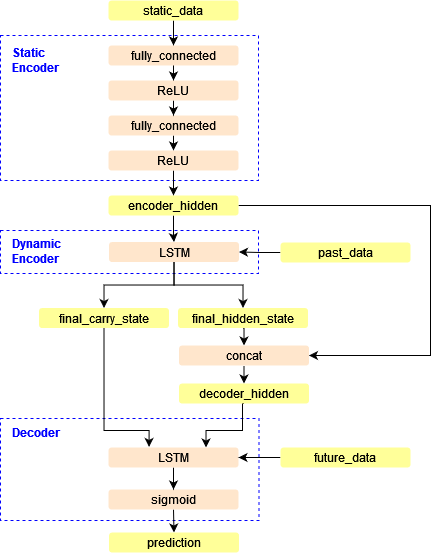

## The Static Encoder

In [18]:
class StaticEncoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, dropout_rate=0.1):
        super(StaticEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.linear_1 = nn.Linear(in_features=input_size, out_features=hidden_size, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.linear_2 = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        self.relu = nn.ReLU()

    def forward(self, input_, use_dropout=True):
        output = self.linear_1(input_)
        output = self.relu(output)
        
        if use_dropout:
            output = self.dropout(output)
            
        output = self.linear_2(output)
        output = self.relu(output)
        
        if use_dropout:
            output = self.dropout(output)
        
        return output.view(1, -1, self.hidden_size)
    

## The Sequence Encoder

In [19]:
class SequenceEncoder(nn.Module):

    def __init__(self, n_features, hidden_size, dropout_rate=0.1):
        super(SequenceEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout_rate)
        self.lstm = nn.LSTM(n_features, hidden_size)
        
    def forward(self, input_, hidden, use_dropout=True):
        output, hidden = self.lstm(input_, hidden)
        
        if use_dropout:            
            hidden = (self.dropout(hidden[0]), self.dropout(hidden[1]))
            
        return output, hidden
    
    def init_carry_state(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

## The Sequence Decoder

In [20]:
class Decoder(nn.Module):
    
    def __init__(self, n_features, hidden_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_features = n_features
        self.dropout = nn.Dropout(p=dropout_rate)
        self.lstm = nn.LSTM(n_features, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_, hidden, use_logits=False, use_dropout=True):
        output = F.relu(input_)
        output, hidden = self.lstm(output, hidden)
        
        if use_dropout:
            hidden = (self.dropout(hidden[0]), self.dropout(hidden[1]))
            
        output = self.out(output[0])
        
        if not use_logits:
            output = self.sigmoid(output)
            
        return output, hidden

# Model Initialisation

In [21]:
static_vector_size = static_train.size(1)
n_dynamic_features = dynamic_train.size(2)
hidden_size = 64
dropout_rate = 0.1
n_epochs = 100
initial_learning_rate = 1e-3
# param for learning rate scheduler.  Set to achieve a LR of 1e-4 after ~100 iterations.
gamma = 0.97

In [22]:
# Initialise architecture
static_encoder = StaticEncoder(
    input_size=static_vector_size, hidden_size=hidden_size, dropout_rate=dropout_rate
).to(device)

sequence_encoder = SequenceEncoder(
    n_features=n_dynamic_features, hidden_size=hidden_size, dropout_rate=dropout_rate
).to(device)

# The skip-connection requires us to concatenate the static context vector to the dynamic encoder hidden state.
# Therefore the decoder needs a hidden state 2 x the size of the encoder hidden states.
decoder = Decoder(
    n_features=n_dynamic_features, hidden_size=2*hidden_size, dropout_rate=dropout_rate
).to(device)

In [23]:
# Initialise optimizers
static_encoder_optimizer = optim.Adam(static_encoder.parameters(), lr=initial_learning_rate)
sequence_encoder_optimizer = optim.Adam(sequence_encoder.parameters(), lr=initial_learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=initial_learning_rate)

In [24]:
# Learning rate schedule - important for small, heterogeneous datasets.
static_encoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(static_encoder_optimizer, gamma)
sequence_encoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(sequence_encoder_optimizer, gamma)
decoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(decoder_optimizer, gamma)

In [36]:
# Using a sum rather than a mean for the MSE loss means we can evaluate it either one timestep
# at a time, or across a whole prediction tensor.
loss_fn = nn.MSELoss(reduction='sum')

# Training and Validation Functions

In [26]:
def train(
    static_tensor,
    past_tensor, 
    future_tensor, 
    target_tensor,
    static_encoder, 
    sequence_encoder, 
    decoder,
    static_encoder_optimizer,
    sequence_encoder_optimizer, 
    decoder_optimizer, 
    loss_fn,
    teacher_forcing_ratio=0.5,
    use_logits=True,
    use_dropout=True
):

    batch_size = future_tensor.shape[0]
    lookahead = future_tensor.shape[1] - 1
    
    loss = 0

    static_encoder.zero_grad()
    sequence_encoder.zero_grad()
    decoder.zero_grad()
    
    static_encoder_output = static_encoder(static_tensor, use_dropout=use_dropout)
    
    sequence_encoder_hidden = (
        # Hidden state
        static_encoder_output,
        # Carry state
        sequence_encoder.init_carry_state(batch_size=batch_size)
    )

    sequence_encoder_output, sequence_encoder_hidden = sequence_encoder(
        # Transform to (SEQ x BATCH x FEATURES) for LSTM
        past_tensor.transpose(0,1),
        sequence_encoder_hidden,
        use_dropout=use_dropout
    )
        
    # This is the skip-connection for the context vector
    decoder_hidden = (
        torch.concat([sequence_encoder_hidden[0], static_encoder_output], dim=2),
        torch.concat([sequence_encoder_hidden[1], static_encoder_output], dim=2)
    )
    
    # First decoder input is the first week to be predicted.
    decoder_input = future_tensor[:, 0, :].unsqueeze(0)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Feed one week at a time into the decoder.
    for week in range(lookahead):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, use_logits=use_logits, use_dropout=use_dropout
        )
        
        next_decoder_input = future_tensor[:, week+1, :].unsqueeze(0)
        target = target_tensor[:, week].unsqueeze(1)
        prediction = decoder_output
        loss += loss_fn(prediction, target)
        
        if use_teacher_forcing:
            # If using teacher forcing, the next decoder input remains untouched.
            decoder_input = next_decoder_input
        else:
            # otherwise overwrite the targets in the next input with the prediction
            decoder_input = torch.concat([
                next_decoder_input[:, :, 0:-1], 
                prediction.unsqueeze(0).detach()
            ], dim=2)

    loss.backward()
    
    # TBH exploding gradients was never really a problem in this model.
    torch.nn.utils.clip_grad_norm_(static_encoder.parameters(), max_norm=2., norm_type=2)
    torch.nn.utils.clip_grad_norm_(sequence_encoder.parameters(), max_norm=2., norm_type=2)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=2., norm_type=2)

    static_encoder_optimizer.step()
    sequence_encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / lookahead

For evaluation we disable the gradient tracking and evaluate the loss over a validation set.

In [27]:
def evaluate(
    static_tensor,
    past_tensor, 
    future_tensor,
    target_tensor,
    static_encoder, 
    sequence_encoder, 
    decoder,
    loss_fn,
    use_logits=True,
    use_dropout=True
):

    batch_size = future_tensor.shape[0]
    lookahead = future_tensor.shape[1] - 1
    
    loss = 0

    with torch.no_grad():
        
        static_encoder_output = static_encoder(static_tensor, use_dropout=use_dropout)
    
        sequence_encoder_hidden = (
            # Hidden state
            static_encoder_output,
            # Carry state
            sequence_encoder.init_carry_state(batch_size=batch_size)
        )

        sequence_encoder_output, sequence_encoder_hidden = sequence_encoder(
            # Transform to (SEQ x BATCH x FEATURES) for LSTM
            past_tensor.transpose(0,1),
            sequence_encoder_hidden,
            use_dropout=use_dropout
        )
        
        # This is the skip-connection for the context vector
        decoder_hidden = (
            torch.concat([sequence_encoder_hidden[0], static_encoder_output], dim=2),
            torch.concat([sequence_encoder_hidden[1], static_encoder_output], dim=2)
        )

        # First decoder input is the first week to be predicted.
        decoder_input = future_tensor[:, 0, :].unsqueeze(0)

        # Feed one week at a time into the decoder.
        for week in range(lookahead):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, use_logits=use_logits, use_dropout=use_dropout
            )
            
            next_decoder_input = future_tensor[:, week+1, :].unsqueeze(0)
            target = target_tensor[:, week].unsqueeze(1)
            prediction = decoder_output
            loss += loss_fn(prediction, target)
            
            # overwrite the target in the next input with the prediction
            decoder_input = torch.concat([
                next_decoder_input[:, :, 0:-1], 
                prediction.unsqueeze(0).detach()
            ], dim=2)

        return loss.item() / lookahead

In [28]:
def training_loop(
    train_dataloader,
    test_dataloader,
    static_encoder, 
    sequence_encoder, 
    decoder,
    static_encoder_optimizer,
    sequence_encoder_optimizer, 
    decoder_optimizer, 
    loss_fn,    
    n_epochs=20, 
    teacher_forcing_ratio=0.5, 
    teacher_forcing_gamma=1.
):

    loss_history = []

    for epoch in range(n_epochs):

        training_loss = 0
        validation_loss = 0

        print(f"Epoch {epoch}")

        #Train
        for batch_id, tensors in tqdm(enumerate(train_dataloader)):

            keys, static_tensor, past_tensor, future_tensor, target_tensor = tensors

            training_loss += train(
                static_tensor,
                past_tensor, 
                future_tensor, 
                target_tensor,
                static_encoder, 
                sequence_encoder, 
                decoder,
                static_encoder_optimizer,
                sequence_encoder_optimizer, 
                decoder_optimizer, 
                loss_fn,
                teacher_forcing_ratio=teacher_forcing_ratio,
                use_logits=False,
                use_dropout=True
            )

        training_loss = training_loss / (batch_id + 1)
        print(f"Training one-step-ahead loss: {training_loss}")
        
        static_encoder_scheduler.step()
        sequence_encoder_scheduler.step()
        decoder_scheduler.step()

        # Evaluate
        for batch_id, tensors in tqdm(enumerate(test_dataloader)):

            keys, static_tensor, past_tensor, future_tensor, target_tensor = tensors

            validation_loss += evaluate(
                static_tensor,
                past_tensor, 
                future_tensor, 
                target_tensor,
                static_encoder, 
                sequence_encoder, 
                decoder,
                loss_fn,
                use_logits=False,
                use_dropout=False
            )

        validation_loss = validation_loss / (batch_id + 1) 
        print(f"Validation one-step-ahead loss: {validation_loss}")

        loss_history.append({
            'epoch': epoch, 
            'training_loss': training_loss, 
            'validation_loss': validation_loss
        })
        
        teacher_forcing_ratio = teacher_forcing_ratio * teacher_forcing_gamma
        
    return loss_history        

Note that we are gradually lowering the teacher forcing ratio as we train.  The idea here is that we gradually move towards a situation where there is no teacher forcing, mimicing the situation of predicting a real time series.  This does, of course, affect the shape of the training loss curve: it will decay slightly more quickly than it otherwise would.

The model is too simple to warrant using the Tensorboard.

In [29]:
loss_history = training_loop(
    train_dataloader,
    test_dataloader,
    static_encoder, 
    sequence_encoder, 
    decoder,
    static_encoder_optimizer,
    sequence_encoder_optimizer, 
    decoder_optimizer, 
    loss_fn,    
    n_epochs=n_epochs, 
    teacher_forcing_ratio=0.25, 
    teacher_forcing_gamma=0.95
)

Epoch 0


81it [00:01, 52.47it/s]


Training one-step-ahead loss: 0.5865979629616023


16it [00:00, 192.77it/s]


Validation one-step-ahead loss: 0.40566247204939526
Epoch 1


81it [00:01, 70.62it/s]


Training one-step-ahead loss: 0.5569643262973047


16it [00:00, 183.82it/s]


Validation one-step-ahead loss: 0.3598521120018429
Epoch 2


81it [00:01, 70.12it/s]


Training one-step-ahead loss: 0.5426649284460904


16it [00:00, 188.16it/s]


Validation one-step-ahead loss: 0.33666051758660215
Epoch 3


81it [00:01, 69.89it/s]


Training one-step-ahead loss: 0.36737306607664866


16it [00:00, 172.05it/s]


Validation one-step-ahead loss: 0.13087465634776485
Epoch 4


81it [00:01, 68.94it/s]


Training one-step-ahead loss: 0.2881085229386026


16it [00:00, 200.01it/s]


Validation one-step-ahead loss: 0.12148721184995437
Epoch 5


81it [00:01, 68.70it/s]


Training one-step-ahead loss: 0.3159434922928674


16it [00:00, 197.64it/s]


Validation one-step-ahead loss: 0.10602404591110019
Epoch 6


81it [00:01, 69.95it/s]


Training one-step-ahead loss: 0.23468775366559436


16it [00:00, 195.12it/s]


Validation one-step-ahead loss: 0.1470685419109133
Epoch 7


81it [00:01, 70.59it/s]


Training one-step-ahead loss: 0.2234023905094758


16it [00:00, 192.77it/s]


Validation one-step-ahead loss: 0.1729520137111346
Epoch 8


81it [00:01, 70.43it/s]


Training one-step-ahead loss: 0.18807454730175815


16it [00:00, 195.05it/s]


Validation one-step-ahead loss: 0.08277975167665215
Epoch 9


81it [00:01, 66.89it/s]


Training one-step-ahead loss: 0.15884516865464723


16it [00:00, 199.92it/s]


Validation one-step-ahead loss: 0.09333654410309263
Epoch 10


81it [00:01, 66.12it/s]


Training one-step-ahead loss: 0.14515732901250056


16it [00:00, 173.92it/s]


Validation one-step-ahead loss: 0.06085388114054998
Epoch 11


81it [00:01, 62.45it/s]


Training one-step-ahead loss: 0.14654399329906306


16it [00:00, 153.85it/s]


Validation one-step-ahead loss: 0.10260731354355813
Epoch 12


81it [00:01, 67.22it/s]


Training one-step-ahead loss: 0.1413183573260392


16it [00:00, 173.92it/s]


Validation one-step-ahead loss: 0.09429203853425053
Epoch 13


81it [00:01, 64.80it/s]


Training one-step-ahead loss: 0.13267428107018006


16it [00:00, 190.51it/s]


Validation one-step-ahead loss: 0.07750346014897029
Epoch 14


81it [00:01, 68.07it/s]


Training one-step-ahead loss: 0.13442291621890418


16it [00:00, 177.78it/s]


Validation one-step-ahead loss: 0.07119105859763092
Epoch 15


81it [00:01, 66.39it/s]


Training one-step-ahead loss: 0.12138473133164336


16it [00:00, 195.10it/s]


Validation one-step-ahead loss: 0.059678916715913355
Epoch 16


81it [00:01, 69.78it/s]


Training one-step-ahead loss: 0.10778186315944002


16it [00:00, 195.13it/s]


Validation one-step-ahead loss: 0.06288392055365774
Epoch 17


81it [00:01, 69.07it/s]


Training one-step-ahead loss: 0.10563652970622432


16it [00:00, 195.13it/s]


Validation one-step-ahead loss: 0.048617628403007984
Epoch 18


81it [00:01, 69.23it/s]


Training one-step-ahead loss: 0.10719739289031928


16it [00:00, 197.53it/s]


Validation one-step-ahead loss: 0.062262105238106505
Epoch 19


81it [00:01, 70.71it/s]


Training one-step-ahead loss: 0.09849543107062862


16it [00:00, 171.98it/s]


Validation one-step-ahead loss: 0.07077355848418343
Epoch 20


81it [00:01, 69.23it/s]


Training one-step-ahead loss: 0.09124810026833387


16it [00:00, 199.91it/s]


Validation one-step-ahead loss: 0.044509808222452804
Epoch 21


81it [00:01, 69.34it/s]


Training one-step-ahead loss: 0.09164163077809682


16it [00:00, 199.92it/s]


Validation one-step-ahead loss: 0.038826936441991075
Epoch 22


81it [00:01, 68.59it/s]


Training one-step-ahead loss: 0.09428806821668755


16it [00:00, 210.52it/s]


Validation one-step-ahead loss: 0.05789439690609774
Epoch 23


81it [00:01, 68.24it/s]


Training one-step-ahead loss: 0.08471465077051901


16it [00:00, 163.25it/s]


Validation one-step-ahead loss: 0.053634830440084144
Epoch 24


81it [00:01, 68.77it/s]


Training one-step-ahead loss: 0.08125848826966335


16it [00:00, 205.04it/s]


Validation one-step-ahead loss: 0.04364438582625654
Epoch 25


81it [00:01, 70.19it/s]


Training one-step-ahead loss: 0.07937494842195057


16it [00:00, 205.05it/s]


Validation one-step-ahead loss: 0.056292453366849154
Epoch 26


81it [00:01, 70.46it/s]


Training one-step-ahead loss: 0.08428499820055788


16it [00:00, 190.48it/s]


Validation one-step-ahead loss: 0.05774727173977428
Epoch 27


81it [00:01, 71.45it/s]


Training one-step-ahead loss: 0.07649675722965979


16it [00:00, 195.13it/s]


Validation one-step-ahead loss: 0.035002962272200316
Epoch 28


81it [00:01, 70.00it/s]


Training one-step-ahead loss: 0.07091545991200968


16it [00:00, 205.05it/s]


Validation one-step-ahead loss: 0.035264659155574106
Epoch 29


81it [00:01, 69.53it/s]


Training one-step-ahead loss: 0.07255449621275128


16it [00:00, 205.13it/s]


Validation one-step-ahead loss: 0.04550289197100533
Epoch 30


81it [00:01, 69.53it/s]


Training one-step-ahead loss: 0.07032203922669089


16it [00:00, 195.12it/s]


Validation one-step-ahead loss: 0.035341963689360344
Epoch 31


81it [00:01, 70.35it/s]


Training one-step-ahead loss: 0.06757759050413739


16it [00:00, 195.13it/s]


Validation one-step-ahead loss: 0.0399466964105765
Epoch 32


81it [00:01, 69.83it/s]


Training one-step-ahead loss: 0.068736682274214


16it [00:00, 202.44it/s]


Validation one-step-ahead loss: 0.04838693162633313
Epoch 33


81it [00:01, 69.49it/s]


Training one-step-ahead loss: 0.06422030261943863


16it [00:00, 207.71it/s]


Validation one-step-ahead loss: 0.03658555975804727
Epoch 34


81it [00:01, 69.58it/s]


Training one-step-ahead loss: 0.06913801339877812


16it [00:00, 190.37it/s]


Validation one-step-ahead loss: 0.07386952121224667
Epoch 35


81it [00:01, 70.10it/s]


Training one-step-ahead loss: 0.07226460380543574


16it [00:00, 192.70it/s]


Validation one-step-ahead loss: 0.0351267276952664
Epoch 36


81it [00:01, 68.86it/s]


Training one-step-ahead loss: 0.07485663349164036


16it [00:00, 202.54it/s]


Validation one-step-ahead loss: 0.032833782542083
Epoch 37


81it [00:01, 70.58it/s]


Training one-step-ahead loss: 0.06352407572118995


16it [00:00, 181.83it/s]


Validation one-step-ahead loss: 0.04156339158200555
Epoch 38


81it [00:01, 70.02it/s]


Training one-step-ahead loss: 0.06001894167830098


16it [00:00, 179.78it/s]


Validation one-step-ahead loss: 0.03521881542272037
Epoch 39


81it [00:01, 68.31it/s]


Training one-step-ahead loss: 0.061061746155937666


16it [00:00, 202.54it/s]


Validation one-step-ahead loss: 0.03927356035759051
Epoch 40


81it [00:01, 70.52it/s]


Training one-step-ahead loss: 0.06030354798044524


16it [00:00, 195.14it/s]


Validation one-step-ahead loss: 0.038466549892392427
Epoch 41


81it [00:01, 69.83it/s]


Training one-step-ahead loss: 0.060834546986103674


16it [00:00, 192.91it/s]


Validation one-step-ahead loss: 0.03478104165858692
Epoch 42


81it [00:01, 69.44it/s]


Training one-step-ahead loss: 0.05968782428360771


16it [00:00, 195.13it/s]


Validation one-step-ahead loss: 0.043672235061724976
Epoch 43


81it [00:01, 69.95it/s]


Training one-step-ahead loss: 0.062076232029413814


16it [00:00, 197.47it/s]


Validation one-step-ahead loss: 0.03828408631185691
Epoch 44


81it [00:01, 70.18it/s]


Training one-step-ahead loss: 0.0577746901165474


16it [00:00, 207.70it/s]


Validation one-step-ahead loss: 0.04645661502662632
Epoch 45


81it [00:01, 69.95it/s]


Training one-step-ahead loss: 0.05443438927966218


16it [00:00, 181.82it/s]


Validation one-step-ahead loss: 0.03304684545016951
Epoch 46


81it [00:01, 68.38it/s]


Training one-step-ahead loss: 0.05415292497116189


16it [00:00, 188.24it/s]


Validation one-step-ahead loss: 0.02981457781667511
Epoch 47


81it [00:01, 67.90it/s]


Training one-step-ahead loss: 0.052269385322744465


16it [00:00, 173.91it/s]


Validation one-step-ahead loss: 0.03100454351968235
Epoch 48


81it [00:01, 66.43it/s]


Training one-step-ahead loss: 0.05219548598279351


16it [00:00, 197.41it/s]


Validation one-step-ahead loss: 0.035366016336613224
Epoch 49


81it [00:01, 64.90it/s]


Training one-step-ahead loss: 0.054590700360319114


16it [00:00, 161.56it/s]


Validation one-step-ahead loss: 0.030755341466930177
Epoch 50


81it [00:01, 68.47it/s]


Training one-step-ahead loss: 0.05257647021562474


16it [00:00, 207.71it/s]


Validation one-step-ahead loss: 0.04855040191776223
Epoch 51


81it [00:01, 70.61it/s]


Training one-step-ahead loss: 0.052596151317752096


16it [00:00, 190.42it/s]


Validation one-step-ahead loss: 0.033772050713499396
Epoch 52


81it [00:01, 69.13it/s]


Training one-step-ahead loss: 0.051432176422843874


16it [00:00, 205.13it/s]


Validation one-step-ahead loss: 0.029350348644786407
Epoch 53


81it [00:01, 68.41it/s]


Training one-step-ahead loss: 0.04936633243727585


16it [00:00, 190.48it/s]


Validation one-step-ahead loss: 0.03648267075833347
Epoch 54


81it [00:01, 68.74it/s]


Training one-step-ahead loss: 0.050947111984012236


16it [00:00, 174.00it/s]


Validation one-step-ahead loss: 0.03301217024111085
Epoch 55


81it [00:01, 69.77it/s]


Training one-step-ahead loss: 0.05174086152975777


16it [00:00, 210.45it/s]


Validation one-step-ahead loss: 0.03364608147078091
Epoch 56


81it [00:01, 70.31it/s]


Training one-step-ahead loss: 0.04813397366078303


16it [00:00, 192.78it/s]


Validation one-step-ahead loss: 0.03131026505596108
Epoch 57


81it [00:01, 70.12it/s]


Training one-step-ahead loss: 0.0499899771846371


16it [00:00, 207.59it/s]


Validation one-step-ahead loss: 0.032589271250698305
Epoch 58


81it [00:01, 70.62it/s]


Training one-step-ahead loss: 0.04607965592780395


16it [00:00, 190.48it/s]


Validation one-step-ahead loss: 0.03423974952763982
Epoch 59


81it [00:01, 67.95it/s]


Training one-step-ahead loss: 0.04788650122607851


16it [00:00, 173.92it/s]


Validation one-step-ahead loss: 0.03185190457022852
Epoch 60


81it [00:01, 69.92it/s]


Training one-step-ahead loss: 0.04699567094220384


16it [00:00, 175.83it/s]


Validation one-step-ahead loss: 0.03879482883753048
Epoch 61


81it [00:01, 68.76it/s]


Training one-step-ahead loss: 0.047326953792931774


16it [00:00, 188.32it/s]


Validation one-step-ahead loss: 0.029657183939384088
Epoch 62


81it [00:01, 69.09it/s]


Training one-step-ahead loss: 0.04968395271173721


16it [00:00, 202.53it/s]


Validation one-step-ahead loss: 0.03813529863125748
Epoch 63


81it [00:01, 68.56it/s]


Training one-step-ahead loss: 0.04513041180429471


16it [00:00, 163.27it/s]


Validation one-step-ahead loss: 0.029643545030719705
Epoch 64


81it [00:01, 69.84it/s]


Training one-step-ahead loss: 0.04656479168116066


16it [00:00, 190.48it/s]


Validation one-step-ahead loss: 0.029786177186502352
Epoch 65


81it [00:01, 69.17it/s]


Training one-step-ahead loss: 0.04698552662412164


16it [00:00, 207.80it/s]


Validation one-step-ahead loss: 0.02859414513740275
Epoch 66


81it [00:01, 68.70it/s]


Training one-step-ahead loss: 0.044886630851218405


16it [00:00, 200.03it/s]


Validation one-step-ahead loss: 0.03699695153368844
Epoch 67


81it [00:01, 69.99it/s]


Training one-step-ahead loss: 0.04524231085295704


16it [00:00, 205.05it/s]


Validation one-step-ahead loss: 0.03628969151112768
Epoch 68


81it [00:01, 70.05it/s]


Training one-step-ahead loss: 0.04318573666207585


16it [00:00, 205.20it/s]


Validation one-step-ahead loss: 0.030827815954883892
Epoch 69


81it [00:01, 68.73it/s]


Training one-step-ahead loss: 0.04632891003241755


16it [00:00, 186.05it/s]


Validation one-step-ahead loss: 0.032555085399912455
Epoch 70


81it [00:01, 69.18it/s]


Training one-step-ahead loss: 0.044206336523892956


16it [00:00, 213.33it/s]


Validation one-step-ahead loss: 0.028628488692144557
Epoch 71


81it [00:01, 70.05it/s]


Training one-step-ahead loss: 0.04214177743642909


16it [00:00, 207.78it/s]


Validation one-step-ahead loss: 0.02784057199541065
Epoch 72


81it [00:01, 68.90it/s]


Training one-step-ahead loss: 0.045510255382875335


16it [00:00, 199.98it/s]


Validation one-step-ahead loss: 0.03347853322823842
Epoch 73


81it [00:01, 70.11it/s]


Training one-step-ahead loss: 0.04277079379689382


16it [00:00, 207.80it/s]


Validation one-step-ahead loss: 0.0368352865593301
Epoch 74


81it [00:01, 67.90it/s]


Training one-step-ahead loss: 0.041604501086661506


16it [00:00, 192.79it/s]


Validation one-step-ahead loss: 0.026817709414495364
Epoch 75


81it [00:01, 68.70it/s]


Training one-step-ahead loss: 0.04099206323639601


16it [00:00, 205.13it/s]


Validation one-step-ahead loss: 0.029357438389625814
Epoch 76


81it [00:01, 69.59it/s]


Training one-step-ahead loss: 0.041629792907784985


16it [00:00, 181.75it/s]


Validation one-step-ahead loss: 0.030881076430281002
Epoch 77


81it [00:01, 69.80it/s]


Training one-step-ahead loss: 0.041946609835402306


16it [00:00, 197.54it/s]


Validation one-step-ahead loss: 0.030042661250465445
Epoch 78


81it [00:01, 69.93it/s]


Training one-step-ahead loss: 0.04076729288173964


16it [00:00, 188.24it/s]


Validation one-step-ahead loss: 0.030630978134771183
Epoch 79


81it [00:01, 69.85it/s]


Training one-step-ahead loss: 0.04103009820761179


16it [00:00, 181.82it/s]


Validation one-step-ahead loss: 0.02811822802242306
Epoch 80


81it [00:01, 70.01it/s]


Training one-step-ahead loss: 0.04157439150192118


16it [00:00, 205.13it/s]


Validation one-step-ahead loss: 0.02747614826593135
Epoch 81


81it [00:01, 69.36it/s]


Training one-step-ahead loss: 0.03953068154584232


16it [00:00, 177.79it/s]


Validation one-step-ahead loss: 0.029826846180690657
Epoch 82


81it [00:01, 69.49it/s]


Training one-step-ahead loss: 0.03977669337036189


16it [00:00, 200.00it/s]


Validation one-step-ahead loss: 0.029805637740840513
Epoch 83


81it [00:01, 69.99it/s]


Training one-step-ahead loss: 0.039285839278511564


16it [00:00, 197.45it/s]


Validation one-step-ahead loss: 0.02948514196193881
Epoch 84


81it [00:01, 67.41it/s]


Training one-step-ahead loss: 0.040071194988914295


16it [00:00, 188.24it/s]


Validation one-step-ahead loss: 0.028153948071930147
Epoch 85


81it [00:01, 69.35it/s]


Training one-step-ahead loss: 0.041418945598218


16it [00:00, 205.07it/s]


Validation one-step-ahead loss: 0.028001425787806507
Epoch 86


81it [00:01, 69.54it/s]


Training one-step-ahead loss: 0.03917275236814766


16it [00:00, 202.57it/s]


Validation one-step-ahead loss: 0.02825716717375649
Epoch 87


81it [00:01, 68.60it/s]


Training one-step-ahead loss: 0.03808768814115367


16it [00:00, 173.85it/s]


Validation one-step-ahead loss: 0.02947845465193192
Epoch 88


81it [00:01, 69.54it/s]


Training one-step-ahead loss: 0.04005443806592655


16it [00:00, 183.92it/s]


Validation one-step-ahead loss: 0.029495007255011134
Epoch 89


81it [00:01, 70.35it/s]


Training one-step-ahead loss: 0.039855116188771446


16it [00:00, 190.48it/s]


Validation one-step-ahead loss: 0.02614847632745902
Epoch 90


81it [00:01, 68.91it/s]


Training one-step-ahead loss: 0.039074132313494485


16it [00:00, 192.88it/s]


Validation one-step-ahead loss: 0.028775363539656002
Epoch 91


81it [00:01, 70.15it/s]


Training one-step-ahead loss: 0.037861960839137766


16it [00:00, 197.44it/s]


Validation one-step-ahead loss: 0.02647439452509085
Epoch 92


81it [00:01, 70.24it/s]


Training one-step-ahead loss: 0.03798864961988886


16it [00:00, 190.41it/s]


Validation one-step-ahead loss: 0.03291131607774231
Epoch 93


81it [00:01, 69.37it/s]


Training one-step-ahead loss: 0.03845147184506365


16it [00:00, 205.05it/s]


Validation one-step-ahead loss: 0.029091310790843428
Epoch 94


81it [00:01, 69.84it/s]


Training one-step-ahead loss: 0.037101080071370134


16it [00:00, 205.13it/s]


Validation one-step-ahead loss: 0.031162020129462082
Epoch 95


81it [00:01, 69.17it/s]


Training one-step-ahead loss: 0.040366254195019026


16it [00:00, 205.09it/s]


Validation one-step-ahead loss: 0.03025852267940839
Epoch 96


81it [00:01, 69.56it/s]


Training one-step-ahead loss: 0.03975477499889902


16it [00:00, 192.78it/s]


Validation one-step-ahead loss: 0.02852464084410005
Epoch 97


81it [00:01, 70.08it/s]


Training one-step-ahead loss: 0.03801443242814152


16it [00:00, 213.34it/s]


Validation one-step-ahead loss: 0.028844822715553976
Epoch 98


81it [00:01, 70.92it/s]


Training one-step-ahead loss: 0.036546549676765475


16it [00:00, 202.53it/s]


Validation one-step-ahead loss: 0.027096884842548106
Epoch 99


81it [00:01, 70.27it/s]


Training one-step-ahead loss: 0.03726333085657065


16it [00:00, 205.02it/s]

Validation one-step-ahead loss: 0.026291349074906767


<AxesSubplot:xlabel='epoch', ylabel='value'>

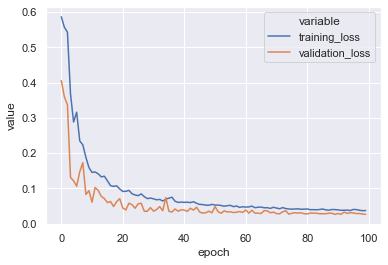

In [30]:
sns.lineplot(
    data=(
        pd.DataFrame(loss_history)
        .melt(id_vars='epoch', value_vars=['training_loss', 'validation_loss'])
    ),
    x='epoch',
    y='value',
    hue='variable'
)

Note that the use of dropout has been switched off for the validation, hence the loss is lower than the training loss.

# Sampling some predictions

In [31]:
def predict(
    static_tensor,
    past_tensor, 
    future_tensor, 
    static_encoder, 
    sequence_encoder, 
    decoder
):

    batch_size = future_tensor.shape[0]
    lookahead = future_tensor.shape[1]
    
    predictions = torch.zeros(batch_size, lookahead)
    
    loss = 0

    with torch.no_grad():
        
        static_encoder_output = static_encoder(static_tensor, use_dropout=False)
        
        sequence_encoder_hidden = (
            # Hidden state
            static_encoder_output,
            # Carry state
            sequence_encoder.init_carry_state(batch_size=batch_size)
        )

        sequence_encoder_output, sequence_encoder_hidden = sequence_encoder(
            # Transform to (SEQ x BATCH x FEATURES) for LSTM
            past_tensor.transpose(0,1),
            sequence_encoder_hidden,
            use_dropout=False
        )

        # This is the skip-connection for the context vector
        decoder_hidden = (
            torch.concat([sequence_encoder_hidden[0], static_encoder_output], dim=2),
            torch.concat([sequence_encoder_hidden[1], static_encoder_output], dim=2)
        )

        # First decoder input is the first week to be predicted.
        decoder_input = future_tensor[:, 0, :].unsqueeze(0)

        # Feed one week at a time into the decoder.
        for week in range(lookahead):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, use_logits=False, use_dropout=False)
            
            # Record the prediction for the output
            prediction = decoder_output
            predictions[:, week] = prediction
            
            if week < lookahead - 1:
                next_decoder_input = future_tensor[:, week+1, :].unsqueeze(0)
                
                # overwrite the targets in the next input with the prediction
                decoder_input = torch.concat([
                    next_decoder_input[:, :, 0:-1], 
                    prediction.unsqueeze(0).detach()
                ], dim=2)    

        return predictions

The plotting function lets me pull out performances by their key, or sample from a dataset.

In [32]:
def plot_predictions(dataset, selected_keys=None, num_performances=1, plot=True, return_data=True):
    
    if selected_keys is not None:
        num_performances = len(selected_keys)
        it = iter(selected_keys)
    else:
        predict_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
        it = iter(predict_dataloader)
        if num_performances == -1:
            num_performances = len(dataset)
    
    for i in range(num_performances):
        if selected_keys is not None:            
            key, static_tensor, past_tensor, future_tensor, target_tensor = dataset.get_by_key(next(it))
            key = key
            static_tensor = static_tensor.unsqueeze(0)
            past_tensor = past_tensor.unsqueeze(0)
            future_tensor = future_tensor.unsqueeze(0)
            target_tensor = target_tensor.unsqueeze(0)
        else:
            key, static_tensor, past_tensor, future_tensor, target_tensor = next(it)
            key = key.item()

        prediction = predict(
            static_tensor,
            past_tensor, 
            future_tensor, 
            static_encoder, 
            sequence_encoder, 
            decoder
        )[0]

        future = target_tensor.squeeze()
        history = past_tensor[0, :, -1]   

        loss = loss_fn(prediction.to(device), future).item()
        
        history_df = pd.DataFrame(
            [
                {'Series': 'History', 'Week': w, 'pct.capacity': h.item()} 
                for w, h in enumerate(history)
            ]
        )
        
        future_df = pd.DataFrame(
            [
                {'Series': 'Future', 'Week': lookback + w, 'pct.capacity': f.item()}
                for w, f in enumerate(future)
            ]
        )
        
        prediction_df = pd.DataFrame(
            [
                {'Series': 'Prediction', 'Week': lookback + w, 'pct.capacity': p.item()} 
                for w, p in enumerate(prediction)
            ]
        )

        data = pd.concat([history_df, future_df, prediction_df], ignore_index=True)    
        
        if plot:
            plt.figure(figsize=(8, 5))
            
            fig = sns.lineplot(
                data=data,
                x='Week',
                y='pct.capacity',
                hue='Series'        
            )
            
            fig.set(title=f"PERFORMANCE_ID: {key}    LOSS: {np.round(loss, 3)}")
            
            fig.set_ylim(0, 1)
        
        if return_data:
            yield {'performance_id': key, 'loss': loss}

[]

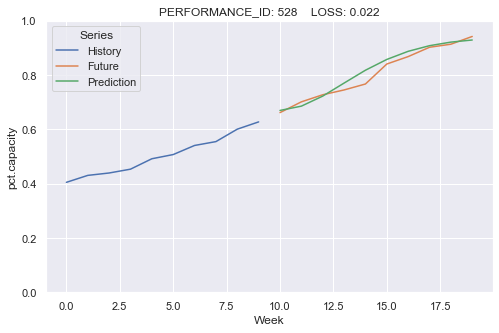

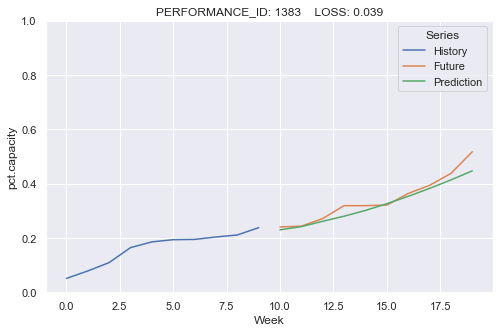

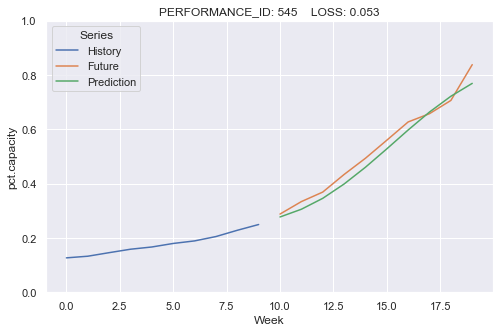

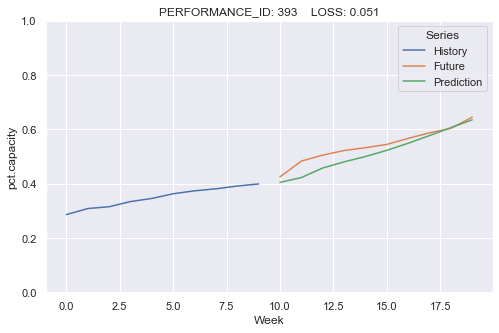

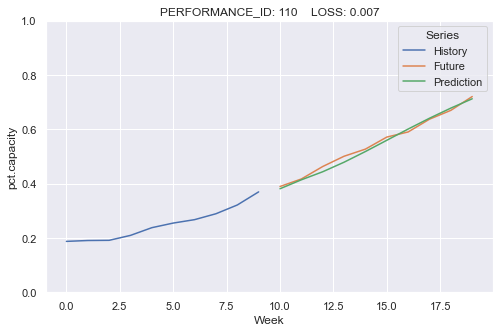

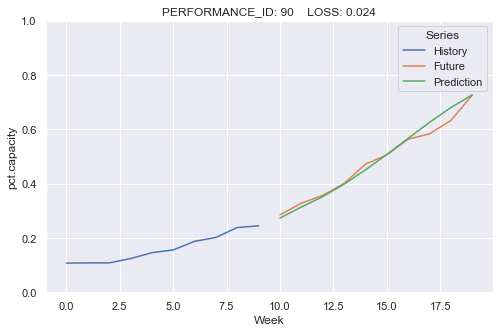

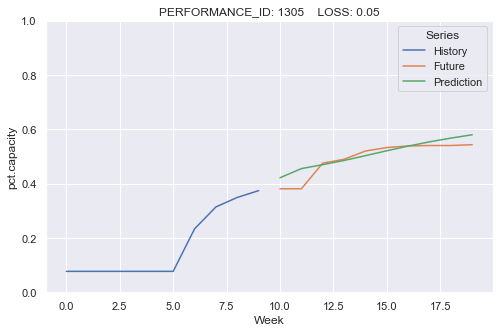

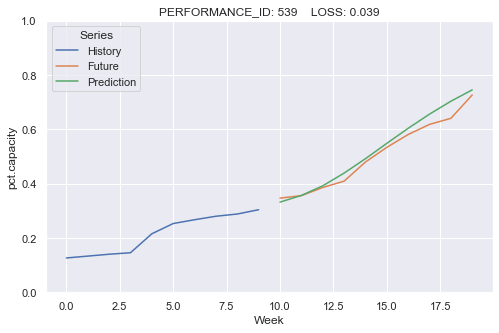

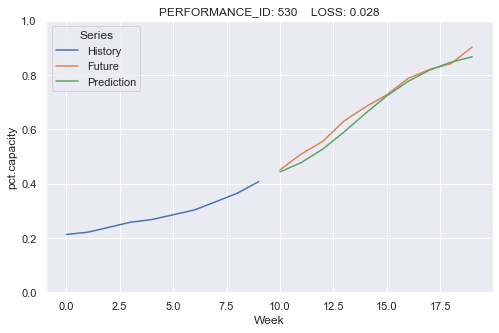

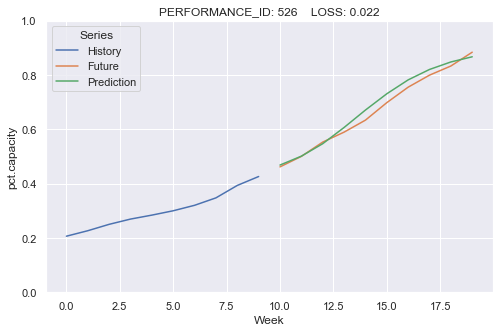

In [34]:
# Sample some of the predictions from the validation set

list(plot_predictions(
    test_dataset, 
    selected_keys=None,
    num_performances=10,
    plot=True, 
    return_data=False
))

 Lovely :-)